In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Factor_classes import StockData, CorrelationMatrix, ComponentsAnalysis, APCA

%load_ext autoreload
%autoreload 2

In [2]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

stock_data = StockData(start_date, end_date)
returns = stock_data.returns
index_returns = stock_data.index_returns

[*********************100%%**********************]  28 of 28 completed
[*********************100%%**********************]  28 of 28 completed
[*********************100%%**********************]  1 of 1 completed


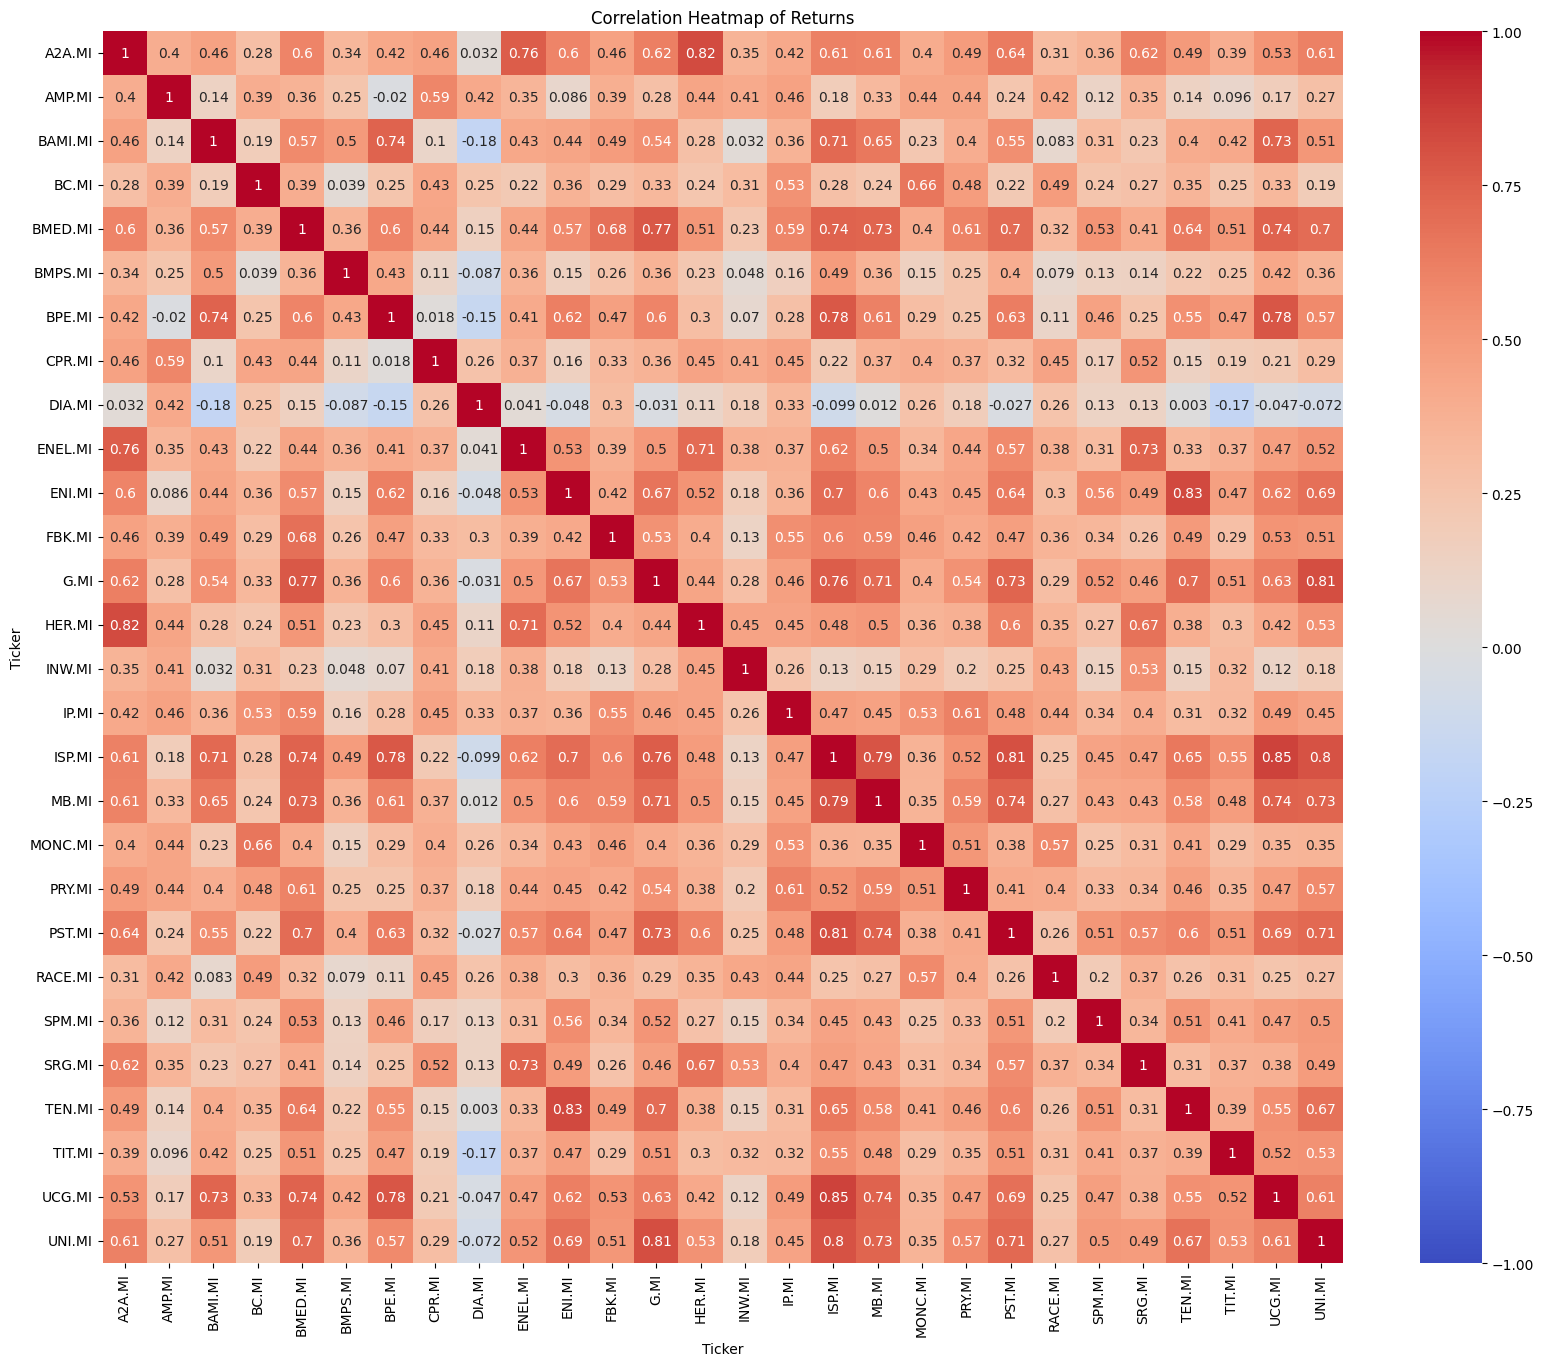

In [3]:
correlation_matrix = CorrelationMatrix(returns)
correlation_matrix.plot_heatmap()

In [4]:
returns.tail(3)

Ticker,A2A.MI,AMP.MI,BAMI.MI,BC.MI,BMED.MI,BMPS.MI,BPE.MI,CPR.MI,DIA.MI,ENEL.MI,...,MONC.MI,PRY.MI,PST.MI,RACE.MI,SPM.MI,SRG.MI,TEN.MI,TIT.MI,UCG.MI,UNI.MI
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-31,-0.036302,-0.057525,0.033469,-0.047368,-0.036450,-0.061018,0.036468,-0.072374,-0.106308,-0.053871,...,-0.116854,0.016411,-0.027875,-0.045036,-0.033333,-0.061186,0.013154,0.028125,0.005291,-0.000776
2023-11-30,0.042084,-0.052874,0.063020,0.044890,-0.052813,0.064156,0.069334,-0.068658,-0.023837,0.018752,...,-0.107597,-0.088021,-0.067977,0.016792,-0.008276,-0.032923,-0.021172,-0.170888,0.042763,-0.006990
2023-12-31,0.117763,0.072312,0.046110,0.004627,0.058610,0.217814,0.116129,-0.040211,0.028687,0.086011,...,0.028921,0.019417,0.064544,0.157062,0.023644,0.071792,0.081826,0.087169,0.056572,0.035198


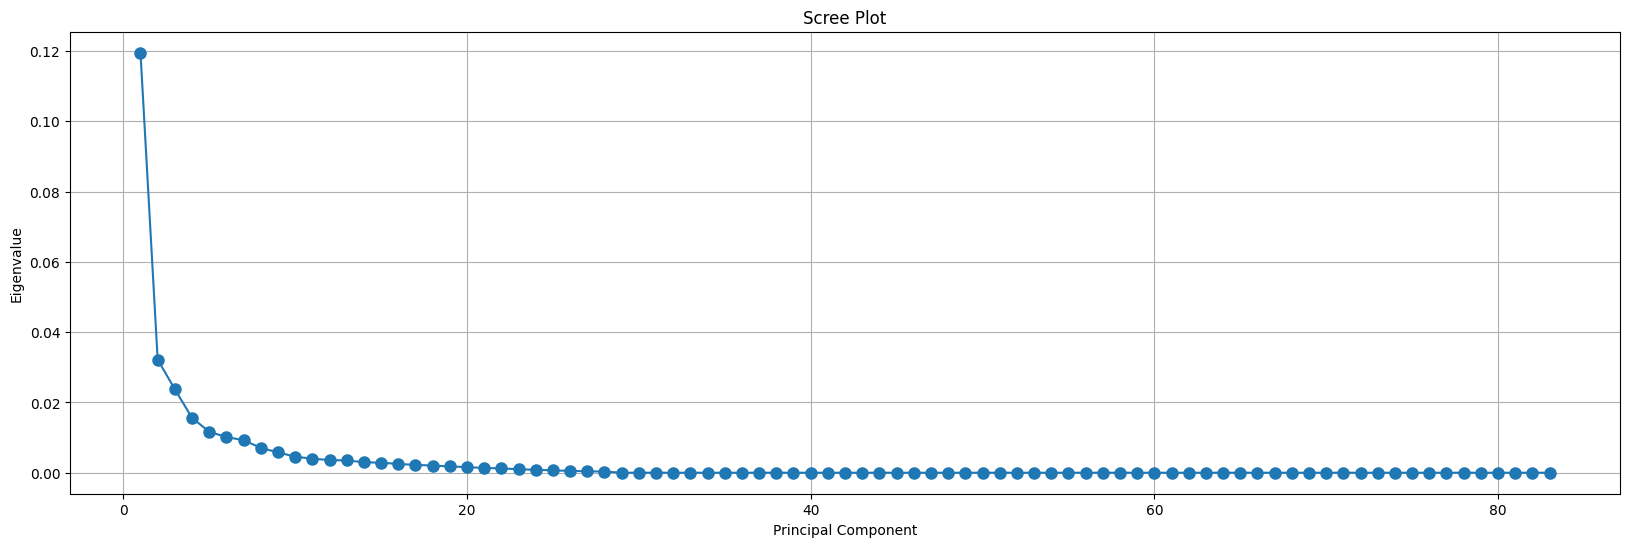

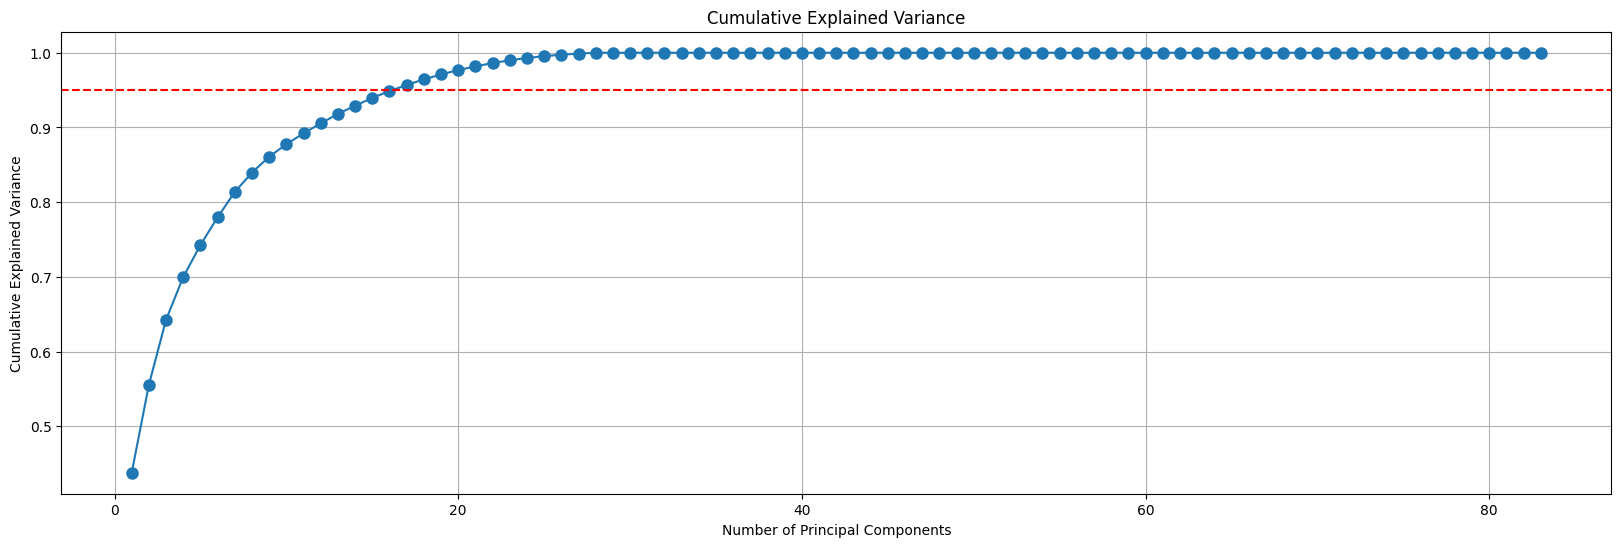

In [5]:
pca_analysis = ComponentsAnalysis(stock_data.returns)
pca_analysis.plot_scree()
pca_analysis.plot_cumulative_explained_variance()

In [6]:
m = 16 #explained variance 95
window_size = 36
max_iterations = 10000
factor_model = APCA(returns, max_iterations=max_iterations)

U_m_final = factor_model.U_m_final
F_final = factor_model.F_final
B_final = factor_model.B_final

## Comincia da qui e non perdere più la borsa - no dai senno non sono piu fun

In [16]:
def rolling_apca_strategy(returns, window_size, max_iterations):
    train_factor_returns = []
    train_factor_loadings = []
    test_index = []
    portfolio_returns = []

    for start in range(len(returns) - window_size):
        long_return = 0
        short_return = 0

        end = start + window_size
        train_returns = returns.iloc[start:end] # t x n
        test_returns = returns.iloc[end:end+1]
        factor_model = APCA(train_returns, max_iterations=max_iterations)
        factor_returns = factor_model.F_final # m x t
        factor_volatility = np.std(factor_returns, axis=0)
        inv_vols = 1 / factor_volatility
        weights = inv_vols / np.sum(inv_vols)

        factor_loadings = factor_model.B_final # n x m
        train_factor_returns.append(factor_returns)
        train_factor_loadings.append(factor_loadings)
        test_index.append(test_returns.index[0])
        weighted_average_factor_returns = np.zeros(factor_loadings.shape[0])

        # for i in range(factor_loadings.shape[1]):
        #     for j in range(factor_returns.shape[1]):
        #         weighted_average_factor_returns += factor_loadings[:, i] * factor_returns[i, j] / window_size
        #     asset_ranks = np.argsort(np.argsort(weighted_average_factor_returns))
        #     top_quintile = asset_ranks >= (len(asset_ranks) * 0.8)
        #     bottom_quintile = asset_ranks <= (len(asset_ranks) * 0.2)
        #     long_weights = np.ones(np.sum(top_quintile)) / np.sum(top_quintile)
        #     short_weights = np.ones(np.sum(bottom_quintile)) / np.sum(bottom_quintile)
        #     long_assets = test_returns.iloc[:, top_quintile]
        #     short_assets = test_returns.iloc[:, bottom_quintile]
        #     long_return += np.dot(long_assets.values.flatten(), long_weights) * weights[i]
        #     short_return += np.dot(short_assets.values.flatten(), short_weights) * weights[i]

        for i in range(factor_loadings.shape[1]):
            asset_ranks = np.argsort(np.argsort(factor_loadings[:, i])) #riguardala
            top_quintile = asset_ranks >= (len(asset_ranks) * 0.8)
            bottom_quintile = asset_ranks <= (len(asset_ranks) * 0.2)
            long_weights = np.ones(np.sum(top_quintile)) / np.sum(top_quintile)
            short_weights = np.ones(np.sum(bottom_quintile)) / np.sum(bottom_quintile)
            long_assets = test_returns.iloc[:, top_quintile]
            short_assets = test_returns.iloc[:, bottom_quintile]
            long_return += np.dot(long_assets.values.flatten(), long_weights) * weights[i]
            short_return += np.dot(short_assets.values.flatten(), short_weights) * weights[i]

        portfolio_return = long_return - short_return
        print(portfolio_return)
        portfolio_returns.append(portfolio_return)

    portfolio_returns_series = pd.Series(portfolio_returns, index=test_index)
    return portfolio_returns_series

In [17]:
portfolio_returns_series = rolling_apca_strategy(returns, window_size, max_iterations)

0.01724550104092509
-0.0036422993758579783
0.0228544186511912
0.005542617538171486
0.02205692826821155
0.005057254645659443
0.033251894761297945
-0.00196293565924713
0.037933491995043964
0.030065673919909903
-0.037081032546802326
0.01383678059362143
-0.013221298353741064
-0.023990976089898336
-0.007331590327127926
0.013398684397985302
-0.012877959346226637
0.00507601719517895
0.011208519014070058
0.0020822119395764796
-0.007933178475590314
0.010755224404701757
-0.020150515851044788
-0.007958468188181349
-0.009607221699598673
0.02113313709308496
-0.010413957521564895
0.00937776309633139
-0.018609317126161668
0.00695225218372101
0.0395123734860471
0.0032259774336963858
0.020460038854894055
0.010252745090453284
-0.009499827200618899
0.0045596598979387604
-0.010147350658583347
0.009726527885553119
-0.010551294861126475
-0.010488941742315443
0.006056616773165789
0.016445303461601675
-0.01804920436467233
-0.0019204340964384496
0.010596874678771188
0.005791478643157024
-0.010205179736547845


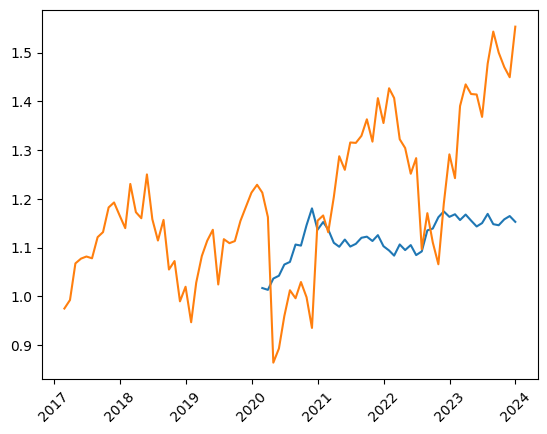

In [18]:
plt.plot((1 + portfolio_returns_series).cumprod())
plt.plot((1 + index_returns).cumprod())
plt.xticks(rotation=45)
plt.show()

In [10]:
def rolling_apca(returns, window_size, max_iterations):
    train_factors_list = []
    loadings_list = []
    test_index_list = [] # bho in caso ti serva
    for start in range(len(returns) - window_size):
        end = start + window_size
        train_returns = returns.iloc[start:end]
        test_returns = returns.iloc[end:end+1]
        factor_model = APCA(train_returns, max_iterations=max_iterations)
        factor_returns = factor_model.F_final
        factor_volatility = np.std(factor_returns, axis=0)
        inv_vols = 1 / factor_volatility
        weights = inv_vols / np.sum(inv_vols)

        B_final = factor_model.B_final
        train_factors_list.append(F_final)
        test_index_list.append(test_returns.index[0])
        loadings_list.append(B_final)
    return train_factors_list, loadings_list, test_index_list

In [11]:
window_size = 36
train_factors, loadings, test_index = rolling_apca(returns, window_size, max_iterations)

In [12]:
def rolling_pca(returns, window_size, n_components):
    train_factors_list = []
    test_factors_list = []
    test_index_list = []
    loadings_list = []
    for start in range(len(returns) - window_size):
        end = start + window_size
        train_data = returns.iloc[start:end]
        test_data = returns.iloc[end:end+1]
        pca = PCA(n_components=n_components)
        pca.fit(train_data)
        train_factors = pca.transform(train_data)
        test_factors = pca.transform(test_data)
        train_factors_list.append(train_factors)
        test_factors_list.append(test_factors)
        test_index_list.append(test_data.index[0])
        loadings_list.append(pca.components_.T)
    return (np.concatenate(train_factors_list), np.concatenate(test_factors_list),
            np.array(loadings_list), test_index_list)

def factor_model_returns(returns, volume_data, loadings, factors, test_index, transaction_cost_rate, slippage_rate=0.005):
    B_list = []
    specific_returns_list = []
    specific_var_list = []
    all_test_factors = []
    factor_model_portfolio_returns = []
    net_returns_list = []
    previous_weights = np.zeros(returns.shape[1])
    portfolio_value = 1
    for i in range(len(test_index)):
        B = loadings[i]
        test_date = test_index[i]
        test_data = returns.loc[test_date:test_date]
        volume_data_date = volume_data.loc[test_date:test_date]
        factor_returns = factors[i].reshape(1, -1)
        all_test_factors.append(factor_returns)
        specific_returns = test_data.values - np.dot(np.dot(test_data.values, B), B.T)
        gross_returns = test_data.dot(B).dot(factor_returns.T) + specific_returns.sum(axis=1)
        gross_returns_value = gross_returns.iloc[0, 0]
        new_weights = B.dot(factor_returns.T).flatten()
        new_weights /= np.sum(np.abs(new_weights))
        weight_changes = np.abs(new_weights - previous_weights)
        transaction_volume = weight_changes * volume_data_date.values.flatten()
        transaction_costs = transaction_volume * transaction_cost_rate
        slippage_costs = transaction_volume * slippage_rate
        total_transaction_costs = np.sum(transaction_costs + slippage_costs)
        net_returns = gross_returns_value - total_transaction_costs / portfolio_value
        net_returns_list.append(net_returns)
        previous_weights = new_weights
        portfolio_value *= (1 + net_returns)
        factor_model_portfolio_returns.append(net_returns)
        specific_var = np.var(specific_returns, axis=1)
        B_list.append(B)
        specific_returns_list.append(specific_returns)
        specific_var_list.append(specific_var)
    
    all_test_factors = np.concatenate(all_test_factors, axis=0)
    factor_cov_matrix = np.cov(all_test_factors.T)
    
    return B_list, specific_returns_list, factor_cov_matrix, specific_var_list, factor_model_portfolio_returns, net_returns_list

In [13]:
pca = PCA().fit(returns.iloc[:window_size])
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

NameError: name 'PCA' is not defined

In [ ]:
transaction_cost_rate = 0
slippage_rate = 0

train_factors, test_factors, loadings, test_index = rolling_pca(returns, window_size, n_components)
B, specific_returns, factor_cov_matrix, specific_var, factor_model_portfolio_returns, net_returns = factor_model_returns(returns, monthly_volume_data, loadings, test_factors, test_index, transaction_cost_rate, slippage_rate)

In [ ]:
factor_model_portfolio_returns = pd.DataFrame(factor_model_portfolio_returns, index=test_index, columns=["Returns"])
test_start_date = returns.index[window_size]
index_returns_test = index_returns[index_returns.index >= test_start_date]
index_cumulative_returns = (1 + index_returns_test).cumprod()
factor_model_cumulative_returns = (1 + factor_model_portfolio_returns).cumprod()
aligned_index_cumulative_returns = index_cumulative_returns.loc[factor_model_cumulative_returns.index]

plt.figure(figsize=(14, 7))
plt.plot(aligned_index_cumulative_returns, label="Buy and Hold FTSE MIB")
plt.plot(factor_model_cumulative_returns, label="Factor Model Strategy")
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Comparison of Buy and Hold FTSE MIB vs Factor Model Strategy')
plt.legend()
plt.grid(True)
plt.show()